# Exploring the BPZ Test Data

_Alex Malz & Phil Marshall_

We have a small dataset to test our `qp` approximations on: 30,000 photometric redshift 1D posterior PDFs, in "gridded" format, from Melissa Graham (UW, LSST). In this notebook we visualize these distributions, and develop machinery to evaluate our approximations on the whole set in "survey mode." 

## Set-up, Ingest

In [25]:
from __future__ import print_function

%load_ext autoreload
%autoreload 2
    
import pickle
import numpy as np
from pathos.multiprocessing import ProcessingPool as Pool
import random
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline

import qp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The data file doesn't appear to come with redshifts at which the PDFs are evaluated, but we are told they're evenly spaced between 0.1 and 3.51.

In [2]:
z = np.arange(0.01, 3.51, 0.01, dtype='float')
# z_range = 3.51 - 0.01
# delta_z = z_range / len(z)

In [3]:
with open('bpz_euclid_test_10_2.probs', 'rb') as data_file:
    lines = (line.split(None) for line in data_file)
    lines.next()
    # lines.next()
    pdfs = np.array([[float(line[k]) for k in range(1,len(line))] for line in lines])
    #pdf_shape = np.shape(pdfs)
    #print(np.sum(pdfs, axis=1)[:100] / zrange)
    #norm_factor = zrange / pdf_shape[1]
    #pdfs /= delta_z
    #print(np.sum(pdfs * zrange, axis=1)[:100])
data_file.close()
#log_pdfs = qp.utils.safelog(pdfs)
#pdfs = np.exp(log_pdfs)
#print(np.sum(pdfs, axis=1)[:100])

[ 350.0175    349.99643   350.001925  350.04025   349.9832    350.0266
  349.986     350.00623   350.004445  349.979     350.03535   349.99916
  349.99195   350.01505   349.99055   349.99986   349.998495  349.9951
  350.01365   349.99545   349.965     349.99951   349.96395   350.0077
  350.003885  349.96675   350.0154    349.9643    350.01218   349.9587
  349.99531   350.        350.01015   350.028     350.0364    349.99874
  349.99965   350.02625   350.0273    350.00119   349.97165   350.002065
  349.9664    350.002065  349.9993    350.0028    350.003115  349.99475
  350.0259    349.991005  350.028     350.00875   349.999545  349.99867
  350.03465   349.996675  350.00469   350.0308    350.01645   350.04515
  350.004235  349.992475  349.997025  349.997515  350.00945   350.00245
  350.003325  349.9811    349.98971   350.005215  350.        349.998215
  350.00315   349.9839    350.04865   350.0126    350.0014    350.006545
  349.993455  350.00693   350.003745  350.00175   350.05425   350

## Visualizing the BPZ $p(z)$'s

Let's plot a few interesting PDFs from the dataset.

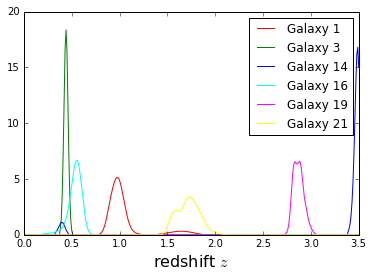

In [4]:
indices = [1, 3, 14, 16, 19, 21]
colors = ['red','green','blue','cyan','magenta','yellow']
for i in range(len(colors)):
    plt.plot(z, pdfs[indices[i]], color=colors[i], label='Galaxy '+str(indices[i]))
plt.xlabel('redshift $z$', fontsize=16)
plt.legend();

Now, let's turn one of them into a `qp.PDF` object initialized with a gridded parametrization.  

Note: The PDFs in the data file weren't properly normalized.  In order to be PDFs, we want $\int\ p(z)\ dz=1$, but the data file entries satisfy $\sum_{z}\ p(z)=1$, which is not the same.  `qp` approximates the desired integral as $\int\ p(z)\ dz\ \approx\ \Delta z\ \sum_{i}^{N}\ p(z_{i})$ where $\Delta z=\frac{z_{max}-z_{min}}{N}$ is the distance between each neighbor pair $i$ of $N$ redshifts at which the PDF is evaluated.

Is your gridded input properly normalized? qp does not check normalization!
Plotted gridded.


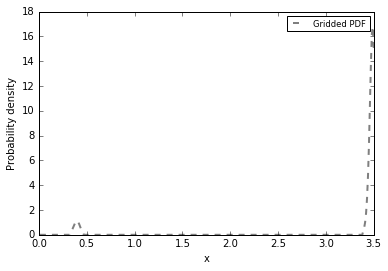

In [5]:
# chosen = random.choice(indices)
# print(chosen)

chosen=14
G = qp.PDF(gridded=(z, pdfs[chosen]))
G.plot()

## Approximating the BPZ $p(z)'s$


Quantile and histogram representations cannot be computed directly from gridded PDFs - we need to make a GMM first, and use this to instantiate a `qp.PDF` object using a `qp.composite` object based on that GMM as `qp.PDF.truth`.  Currently, a GMM can only be fit to samples, so we start by sampling our gridded parametrization.

Plotted gridded.
Interpolating the `samples` parametrization
Creating a `linear` interpolator for the samples parametrization.
Plotted samples


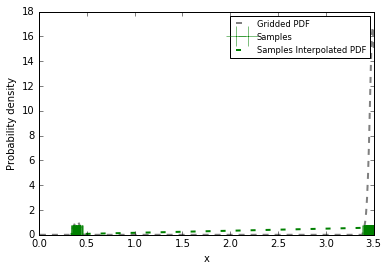

In [6]:
G.sample(1000, vb=False)
G.plot()

Now that there are samples, we can fit the GMM, producing a `qp.composite` object.

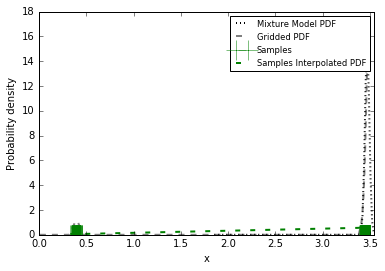

In [7]:
M_dist = G.mix_mod_fit(n_components=2, vb=False)
G.plot(vb=False)

The `qp.composite` object can be used as the `qp.PDF.truth` to initialize a new `qp.PDF` object that doesn't have any information about the gridded or sample approximations.  Now we can approximate it any way we like!

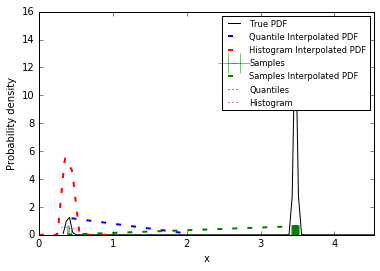

In [8]:
M = qp.PDF(truth=M_dist)
M.quantize(vb=False)
M.histogramize(vb=False)
M.sample(N=100,vb=False)
M.plot(vb=False)

## Quantifying the Accuracy of the Approximation

Let's start by computing the RMSE and KLD between each approximation and the truth, in a sample of systems - and then graduate to looking at the estimated $n(z)$. We'll need a function to do all the analysis on a single object, and then accumulate the outputs to analyze them.

In [9]:
def analyze(index, N_comps, N_floats=5, z, vb=False):
    """
    Model the input BPZ P(z) as a GMM, approximate that GMM in 
    various ways, and assess the quality of each approximation.
    
    Parameters
    ----------
    index : int
        ID of galaxy
    N_comps : int
        Number of components used in GMM
    N_floats : int
        Number of floats used to parametrize the P(z)
    z : float, ndarr
        Redshift array for input gridded "truth". Used for 
        evaluating n(z) too
    vb : boolean
        Verbose output?

    Returns
    -------
    result : dict
        Dictionary containing metric values, n(z) on standard 
        grid, samples, "true" GMM gridded p(z).
        
    Notes
    -----
    In some cases the GMM does not fit well, leading to bad KLD and 
    RMSE values when it is compared to the truth.
    
    """
#     # Make z array if we don't already have it:
#     if z is None:
#         z = np.arange(0.01, 3.51, 0.01, dtype='float')
    dz = (max(z) - min(z)) / len(z)
    zlimits = [min(z), max(z)]

    # Make a dictionary to contain the results:     
    result = {}
    
    # Make a GMM model of the input BPZ p(z) (which are stored
    # in the global 'pdfs' variable:
    G = qp.PDF(gridded=(z, pdfs[index]), vb=vb)
    
    # Draw 1000 samples, fit a GMM model to them, and make a true PDF:
    G.sample(1000, vb=vb)
    GMM = G.mix_mod_fit(n_components=N_comps, vb=vb)
    P = qp.PDF(truth=GMM, vb=vb)
    
    # Evaluate the GMM on the z grid, and store in the result dictionary. We'll 
    # need this to make our "true" n(z) estimator. We don't need to keep the 
    # z array, as we passed that in.
    result['truth'] = P.evaluate(z, using='truth', vb=vb)[1]

    # Now approximate P in various ways, and assess:
    Q, KLD, RMSE, approximation = {}, {}, {}, {}
    Q['quantiles'] = qp.PDF(quantiles=P.quantize(N=N_floats, vb=vb), vb=vb)
    Q['histogram'] = qp.PDF(histogram=P.histogramize(N=N_floats, binrange=zlimits, vb=vb), vb=vb)
    Q['samples'] = qp.PDF(samples=P.sample(N=N_floats, vb=vb), vb=vb)
    for k in Q.keys():
        KLD[k] = qp.calculate_kl_divergence(P, Q[k], limits=zlimits, dx=dz, vb=vb)
        RMSE[k] = qp.calculate_rmse(P, Q[k], limits=zlimits, dx=dz, vb=vb)
        approximation[k] = Q[k].evaluate(z, using=k, vb=vb)[1]
        
    # Store approximations:
    result['KLD'] = KLD
    result['RMSE'] = RMSE
    result['approximation'] = approximation
    result['samples'] = Q['samples'].samples
    
    return result

In [10]:
# N_floats = 100
# x = analyze(14, N_floats=N_floats, z=z, vb=False)

In [11]:
# x.keys()

['KLD', 'approximation', 'samples', 'truth', 'RMSE']

In [12]:
# print(x['approximation']['quantiles'].shape)
# print(x['approximation']['histogram'].shape)
# print(x['approximation']['samples'].shape)
# print(x['truth'].shape)
# print(x['samples'].shape)

(350,)
(350,)
(350,)
(350,)
(100,)


In [13]:
# x['samples']

array([ 3.48879383,  3.50427839,  3.47818914,  3.48497079,  3.48141101,
        3.4906822 ,  3.47504131,  3.49594323,  3.49415105,  3.49885819,
        3.47442238,  3.48188053,  3.50206488,  3.48808677,  3.49455559,
        3.49010751,  3.48559061,  3.49282343,  3.47690903,  3.48988838,
        3.4815    ,  3.49850501,  3.48857339,  3.48814298,  3.49445038,
        3.48638788,  3.49326517,  3.49195603,  3.49640675,  3.48350323,
        0.39636206,  0.4421352 ,  0.42322577,  0.38530469,  0.42028063,
        0.41386075,  0.41019723,  3.4223831 ,  3.45028275,  3.41490796,
        3.45519804,  3.48005744,  3.4398464 ,  3.45318641,  3.43215043,
        3.44664088,  3.47831744,  3.47246035,  3.44102008,  3.47793761,
        3.44532853,  3.41848723,  3.43436437,  3.42857668,  3.43600428,
        3.46446241,  3.43007833,  3.45627389,  3.4360039 ,  3.43958139,
        3.46822651,  3.48464615,  3.46854861,  3.47172462,  3.48432029,
        3.46214099,  3.46992204,  3.47213015,  3.47097331,  3.46

OK, now lets's collate the metrics for the first 100 galaxies over a variable number of parameters, and look at the distribution of metric values.  We're using multiprocessing because a `for` loop would be too slow.  However, it's still really, really slow because of the optimization routine for finding quantiles of a GMM!

In [ ]:
%%time
numbers = [3, 10, 30, 100, 300]
n_numbers = len(numbers)
all_results = {}

def one_analysis(N):
    results = []
    for i in range(100):
        results.append(analyze(i, N_floats=N, z=z))
        if i%10 == 0: print('.', end='')
    all_results[str(N)] = results
    return

pool = Pool(3)
for N in numbers:
    pool.map(one_analysis, numbers)

Since the previous step is quite slow even with multiprocessing, this is a good point to save the results.  We can load them from the file later and not remake them if we only want to do the rest of the analysis.

In [ ]:
with open('all_results.pkl', 'wb') as result_file: 
    pickle.dump(all_results, result_file)

In [ ]:
with open('all_results.pkl', 'rb') as result_file: 
    all_results = pickle.load(result_file)

In [15]:
all_KLD, all_RMSE = [], []
for n in range(n_numbers):
    KLD, RMSE = {}, {}
    for approximation in all_results[str(numbers[n])][0]['KLD'].keys():
        x = np.array([])
        for k in range(len(results)):
            x = np.append(x, all_results[str(numbers[n])][k]['KLD'][approximation])
        KLD[approximation] = x
        x = np.array([])
        for k in range(len(results)):
            x = np.append(x, all_results[str(numbers[n])][k]['RMSE'][approximation])
        RMSE[approximation] = x
    all_KLD.append(KLD)
    all_RMSE.append(RMSE)

Now let's plot histograms of the metric values.

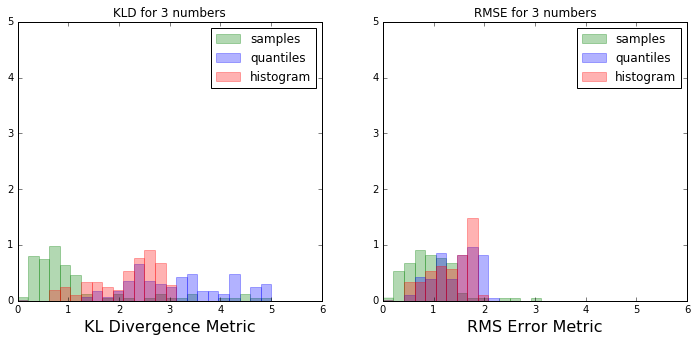

In [16]:
colors = {'samples':'green', 'quantiles':'blue', 'histogram':'red'}
plt.figure(figsize=(12, 5*n_numbers))

i=0
for n in range(n_numbers):
    i += 1
    # Lefthand panel: KLD
    plt.subplot(n_numbers, 2, i)
    plt.title('KLD for '+str(numbers[n])+' numbers')
    bins = np.linspace(0.0, 5, 25)
    for k in ['samples', 'quantiles', 'histogram']:
        plt.hist(all_KLD[n][k], bins, label=k, fc=colors[k], ec=colors[k], alpha=0.3, normed=True)
    #plt.semilogx()
    plt.xlabel('KL Divergence Metric', fontsize=16)
    plt.ylim(0., 5.0)
    plt.legend()
    
    i += 1
    # Righthand panel: RMSE
    plt.subplot(n_numbers, 2, i)#+n_numbers)
    plt.title('RMSE for '+str(numbers[n])+' numbers')
    bins = np.linspace(0.0, 5, 25)
    for k in ['samples', 'quantiles', 'histogram']:
        plt.hist(all_RMSE[n][k], bins, label=k, fc=colors[k], ec=colors[k], alpha=0.3, normed=True)
    #plt.semilogx()
    plt.xlabel('RMS Error Metric', fontsize=16)
    plt.ylim(0., 5.0)
    plt.legend();
    
plt.savefig('money.png')

Interesting: looks like the quantile approximation does better in RMSE, but only slightly better in KLD. Histogram does noticeably worse in both metrics.

KLD seems to flag more "bad" approximations than RMSE. How do we know where to set the threshold in each metric? 

We should think of the right way to get a summary statistic (first moment?) on the ensemble of KLD or RMSE values so we can make the plot of number of parameters vs. quality of approximation.

Now lets compute the estimated $n(z)$. We'll do this with the GMM "truth", and then using each of our approximations. And we'll normalize the $n(z)$ to account for lost systems with bad approximations.

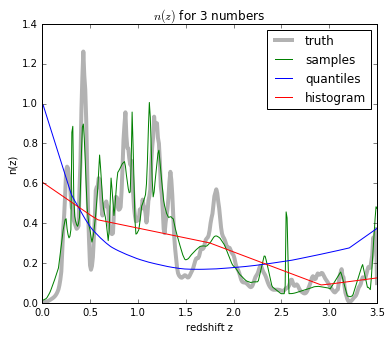

In [17]:
plt.figure(figsize=(6, 5*n_numbers))
all_n = []
all_x = []
all_y = []

for i in range(n_numbers):
    results = all_results[str(numbers[i])]
    n = {}

    # Pull out all truths and compute the average at each z:
    x = np.zeros([len(z), len(results)])
    y = {}
    for approx in ['samples', 'quantiles', 'histogram']:
        y[approx] = np.zeros([len(z), len(results)])
        for k in range(len(results)):
            y[approx][:,k] = results[k]['approximation'][approx] 
    for k in range(len(results)):
        x[:,k] = results[k]['truth'] 

    # Now do the averaging to make the estimators:
    n['truth'] = np.mean(x, axis=1)
    for approx in ['samples', 'quantiles', 'histogram']:
        n[approx] = np.mean(y[approx], axis=1)
        
    all_n.append(n)
    all_x.append(x)
    all_y.append(y)

    # Note: this uses the samples' KDE to make the approximation. We could (and 
    # should!) also try simply concatenating the samples and histogramming them.
    
    # Plot truth and all the approximations. 
    # The NaNs in the histogram approximation make that unplottable for now.
    plt.subplot(n_numbers, 1, i+1)#+n_numbers)
    plt.title(r'$n(z)$ for '+str(numbers[i])+' numbers')
    plt.plot(z, n['truth'], color='black', lw=4, alpha=0.3, label='truth')
    for k in ['samples', 'quantiles', 'histogram']:
        plt.plot(z, n[k], label=k, color=colors[k])
    plt.xlabel('redshift z')
    plt.ylabel('n(z)')
    plt.legend();
plt.savefig('nz_comparison.png')

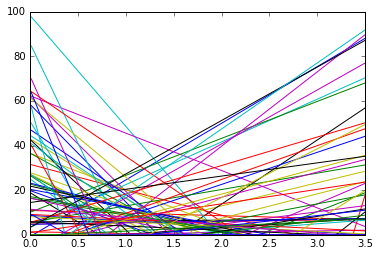

In [18]:
# #print(all_results[0][0]['approximation']['quantiles'])
# plot_y = all_results[0]#[:]['approximation']['quantiles']
# for i in range(100):
#     if np.max(plot_y[i]['approximation']['quantiles']) < 100:
#         plt.plot(z, plot_y[i]['approximation']['quantiles'])

The "samples" approximation seems to give a slightly better result for the $n(z)$ estimator than the "quantiles" approximation; "histogram" is noticeably worse than both. Let's use the `qp.PDF` object to compare them quantitatively (since $n(z)$ can be normalized to give the global $p(z)$).

In [18]:
all_p = []

for i in range(n_numbers):
    n = all_n[i]
    p = {}
    for k in ['samples', 'quantiles', 'histogram']:
        p[k] = qp.PDF(gridded=(z,n[k]), vb=False)

    p['truth'] = qp.PDF(gridded=(z,n['truth']), vb=False)
    
    all_p.append(p)

In [19]:
all_KLD_nz, all_RMSE_nz = {}, {}
zlimits, dz = [0.0, 3.5], 0.01
for k in ['samples', 'quantiles', 'histogram']:
    p = all_p[i]
    KLD_nz, RMSE_nz = [], []
    for i in range(n_numbers):
        KLD_nz.append(qp.calculate_kl_divergence(all_p[i]['truth'], all_p[i][k], limits=zlimits, dx=dz, vb=False))
        RMSE_nz.append(qp.calculate_rmse(all_p[i]['truth'], all_p[i][k], limits=zlimits, dx=dz, vb=False))
    
    all_KLD_nz[k] = KLD_nz
    all_RMSE_nz[k] = RMSE_nz

In [23]:
# print(all_KLD_nz, all_RMSE_nz)

{'quantiles': [0.47200591313819362], 'samples': [0.066270958506803854], 'histogram': [0.2315284715849521]} {'quantiles': [0.31045126363591047], 'samples': [0.11918118724010221], 'histogram': [0.21607448808209742]}


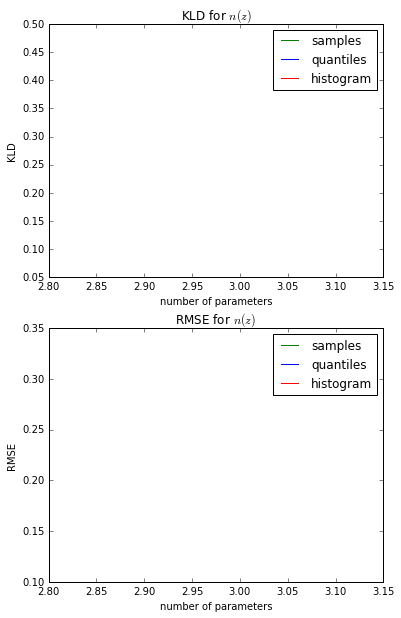

In [21]:
plt.figure(figsize=(6, 10))
both = [plt.subplot(2, 1, i+1) for i in range(2)]
KLD_plot = both[0]
RMSE_plot = both[1]
KLD_plot.set_title(r'KLD for $n(z)$')
RMSE_plot.set_title(r'RMSE for $n(z)$')
KLD_plot.set_xlabel('number of parameters')
RMSE_plot.set_xlabel('number of parameters')
KLD_plot.set_ylabel('KLD')
RMSE_plot.set_ylabel('RMSE')
# KLD_plot.semilogx()
# KLD_plot.semilogy()
# RMSE_plot.semilogx()
# RMSE_plot.semilogy()

for k in ['samples', 'quantiles', 'histogram']:
    KLD_plot.plot(numbers, all_KLD_nz[k], color=colors[k], label=k)
    RMSE_plot.plot(numbers, all_RMSE_nz[k], color=colors[k], label=k)

KLD_plot.legend()
RMSE_plot.legend()
plt.savefig('summary.png')

In [ ]:
print('KLD metrics for n(z) estimator: ', all_KLD_nz)
print('RMSE metrics for n(z) estimator: ', all_RMSE_nz)

This early indication suggests that all three approximations are fairly closely matched in this metric. The rank order of the three methods is the same when the $n(z)$ estimates are compared with the KLD metric and the RMSE metric: from best to worst we have "histogram", "samples" and "quantiles." A bigger test, using the full dataset, should allow this to be tested further: jack-knife error bars shoudl also be calculable. 

A different set of quantile points maygive a different result. Also, it would be interesting to see whether the conclusions about the choice of approximation vary as the number of available stored values is varied away from 100 (to, perhaps, 3, 10, 30, 100, 300). 